https://geopandas.org/mapping.html
https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac

## Libraries & Functions

In [1]:
import pandas as pd
import numpy as np
import pandasql as ps

#libraries for web scrapping
import requests
from bs4 import BeautifulSoup
import urllib.request
import time
import random

#libraries to connect to API
import json

#libraries for visuals
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import seaborn as sns
import shapefile as shp
import geopandas as gpd

#libraries for EDA
from scipy.stats import shapiro

#libraries for decision trees/random forests/SVM/KNN
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from xgboost import XGBClassifier

**Import Universal Reference Data**

In [2]:
#This document will be used in several modules through the notebook
allzipUSA = pd.read_csv("DATA/zip_state_county.csv") #import document with state/county/zipcode info
allzipUSA['zipcode'] = allzipUSA['zipcode'].astype(str)
allzipUSA['zipcode'] = allzipUSA['zipcode'].apply(lambda x: '{0:0>5}'.format(x)) #add leading zeros to len 4 zipcodes

#load county latitude & Longitude
lat_long = pd.read_csv("DATA\county_latit_long.csv")
lat_long.drop(labels=['Unnamed: 0'], inplace=True, axis=1)
lat_long['county'] = lat_long['county'].apply(lambda x: x.upper()) #for consistency across sources

**Functions**

In [3]:
#function to load API Key locally stored
def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [4]:
def print_base_map(shp_path, x_lim = None, y_lim = None, figuresize = (15,9), title = 'Plot'):
    """
    Function to plot map from a shapefile
    shp_path: shapefile path
    x_lim/y_lim: coordinate range to plot (optional)
    """
    shapef = shp.Reader(shp_path) #read shapefile
    fig, ax = plt.subplots(figsize = figuresize)
    fig.suptitle(title, fontsize=14)
    for shape in shapef.shapeRecords(): #BASE MAP
        x = [i[0] for i in shape.shape.points[:]] #fetch x coordinates from shapefile
        y = [i[1] for i in shape.shape.points[:]] #fetch y coordinates from shapefile
        plt.plot(x, y, 'k', linewidth=0.75) #plot each shape in file 
    if (x_lim != None) & (y_lim != None): #check if plot range was specified    
        plt.xlim(x_lim)
        plt.ylim(y_lim)
    return(fig, ax)

In [5]:
def calc_color3(data, color=None):
    """
    Function to create bins and assign color to values
    This function will be used to color the shapefile areas based on the created bins
    
    """
    if color   == 1: 
        color_sq = ['#9e9ac8F0',
                        '#6a51a3F0','#54278fF0']
        colors = 'Purples'
    elif color == 2: 
        color_sq = ['#41b6c4',
                        '#225ea8','#253494']
        colors = 'YlGnBu'
    elif color == 3: 
        color_sq = ['#bdbdbd',
                        '#636363','#252525']
        colors = 'Greys'
    elif color == 9: 
        color_sq = ['#ff0000',
                        '#ff0000','#ff0000']
    else:  
        color_sq = ['#DEA01C',
                        '#C7480D','#8D0919'] 
    new_data, bins = pd.qcut(data, 3, retbins=True, 
                             labels=list(range(3))) #new_data has the category number instead of original value
    color_ton = []
    for val in new_data:
        color_ton.append(color_sq[val]) #store the value corresponding to color sequence based on new_data
    third_patch = mpatches.Patch(color=color_sq[2], label=str(int(bins[2])) + " => " + str(int(bins[3])-1))
    second_patch = mpatches.Patch(color=color_sq[1], label=str(int(bins[1])) + " => " + str(int(bins[2])-1))
    first_patch = mpatches.Patch(color=color_sq[0], label=str(int(bins[0])) + " => " + str(int(bins[1])-1))
    handles=[first_patch, second_patch, third_patch] #handles for plot   
    return color_ton, bins, handles;

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`
    cm=confusion matrix array
    classes=labels of supervised learning
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [7]:
def gridsearch_metrics_scoring(list_fitted_grid, labels, X_test, y_test):
    """
    This function takes a list of fitted GridSearch objects 
    and calculates the evaluation scores and confusion matrix for each item
    """
    for i, g in enumerate(list_fitted_grid):
        y_pred = g.predict(X_test)
        cnf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
        np.set_printoptions(precision=2)
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=labels,
                              title='GridSearch ' + str(i + 1) + ' - Confusion matrix')
        print('***GridSearch {} Report***'.format(str(i + 1)))
        print("Best Parameters: {}".format(g.best_params_))
        print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
        print(classification_report(y_test, y_pred, labels))
        print('\n')

In [8]:
def plot_feature_importances(model):
    """
    This function plots the feature importances of decision trees
    """
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

## DATA ENGINEERING

**Output variables:**

- **var1**: xxxxx
- **var2**: yyy

**General considerations:**
- 827counties will be used for this study since the American Community Survey only presents statistics on those counties. 

### American Community Survey - Data

Data from the United States Census Bureau: https://www.census.gov/data/developers/data-sets/acs-5year.html

Dataset: American Community Survey 5-year Data

API: https://api.census.gov/data/2018/acs/acs1.json?get=[VARIABLESHERE]&for=county:*

API Key request: https://api.census.gov/data/key_signup.html

The American Community Survey (ACS) 5-year data is available down to the county level with an increased level of statistical reliability for small population subgroups. 

827 counties are represented in this survey, therefore I will work with those counties during this study.

<img src="ACS Variable list.png">

**Data Download from API**

In [9]:
#import API Key from local directory
#API keys are sensitive and should not be hard coded to your notebook
keys = get_keys("/Users/franc/.secret/USCensus.json")
api_key = keys['api_key'] 

The variables of the dataset were selected from the ACS 5-year survey on a county level

In [10]:
variable_list = "B01002_002E,B01002_003E,B19013_001E,B25105_001E,B19301_001E"
url = 'https://api.census.gov/data/2018/acs/acs1.json?get=NAME,'+ variable_list +'&for=county:*'
headers = {
        'Authorization': 'Bearer {}'.format(api_key),}
response = requests.get(url, headers=headers).json() #convert data to a json format
ACS_data = pd.DataFrame(response)

**Data Clean**

In [11]:
ACS_data.rename(columns={0: "name", 1: "median_age_male", 2: "median_age_female", 3: "median_household_income", 4: "median_housing_cost", 5: "per_capita_income"}, inplace=True)
ACS_data.drop(ACS_data.index[0], inplace=True) #drop first row after column rename
ACS_data.drop(labels=[6,7], inplace=True, axis=1) #drop unnecessary columns

countyname = ACS_data['name'].str.split(', ', expand=True) #Split name column by comma
ACS_data['county'] = countyname[0]
ACS_data['state_name'] = countyname[1]

ACS_data.loc[ACS_data['county'].str.contains('county|County|Parish|parish'),'county'] = ACS_data['county'].str[:-7] #remove the word "county" from county column

ACS_data = ACS_data.assign(newcounty=ACS_data['county'].str.replace('.', '')) #remove . from county names if any
ACS_data.drop(labels=['county'], inplace=True, axis=1)
ACS_data.rename(columns={'newcounty': "county"}, inplace=True)

rowstodrop = ACS_data.loc[ACS_data['state_name'].isin(['Puerto Rico', 'Alaska', 'Hawaii'])] #exclude from the study
ACS_data = ACS_data.drop(rowstodrop.index)

ACS_data.loc[ACS_data['county'] == "Doña Ana",'county'] = 'DONA ANA' #for consistency across sources

ACS_data['county'] = ACS_data['county'].apply(lambda x: x.upper()) #for consistency across sources

In [12]:
ACS_data

,name,median_age_male,median_age_female,median_household_income,median_housing_cost,per_capita_income,state_name,county
1,"Baldwin County, Alabama",42.5,45.0,56813,941,32704,Alabama,BALDWIN
2,"Calhoun County, Alabama",38.6,41.4,45818,727,24493,Alabama,CALHOUN
3,"Cullman County, Alabama",38.8,42.1,44612,607,25874,Alabama,CULLMAN
4,"DeKalb County, Alabama",38.8,40.5,36998,604,21822,Alabama,DEKALB
5,"Elmore County, Alabama",36.8,41.2,60796,871,26128,Alabama,ELMORE
...,...,...,...,...,...,...,...,...
823,"Waukesha County, Wisconsin",41.5,44.6,86968,1276,46325,Wisconsin,WAUKESHA
824,"Winnebago County, Wisconsin",38.1,39.6,56589,853,31885,Wisconsin,WINNEBAGO
825,"Wood County, Wisconsin",42.2,45.4,55273,715,31272,Wisconsin,WOOD
826,"Laramie County, Wyoming",37.3,38.7,64306,1020,34448,Wyoming,LARAMIE


### **County Selection**

Since the ACS data for the 5-year survey includes only certain counties, I will train my model on that county selection.


In [13]:
county_selection = ACS_data[['county', 'state_name']].copy() #get county and state name of sample under study

df2 = allzipUSA[['state_name', 'state_abbrev']] 
df2.drop_duplicates(keep='first',inplace=True)

county_selection = county_selection.merge(df2, how='left', on=['state_name']) #add state abbreviation to the list of selected counties

county_selection

C:\Users\franc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,county,state_name,state_abbrev
0,BALDWIN,Alabama,AL
1,CALHOUN,Alabama,AL
2,CULLMAN,Alabama,AL
3,DEKALB,Alabama,AL
4,ELMORE,Alabama,AL
...,...,...,...
815,WAUKESHA,Wisconsin,WI
816,WINNEBAGO,Wisconsin,WI
817,WOOD,Wisconsin,WI
818,LARAMIE,Wyoming,WY


In [14]:
#Export list to folder for backup
county_selection.to_csv('DATA/county_selection.csv')

### United States Department of Agriculture - Data



Food Access Research Atlas: https://www.ers.usda.gov/data-products/food-access-research-atlas/download-the-data/

Variable Used: **LOW ACCESS VARIABLE (LATracts_1and10)** -- This index flags cencus tracts as low access if there are no grocery stores wthin 1 mile for urban areas and 10 miles for rural areas.


Food access flag for counties was calculated based on the ratio of **LATracts_1and10/Total Census Tracts per county**. The county was marked as “Low Access” if 50% of the LATracts for the county were flagged as positive in the raw dataset. 

**LA County Flag** is the variable to be used in final dataset

In [15]:
low_access_food = pd.read_csv("DATA/LATracts_1and10.csv")
#Data cleaning 
low_access_food = low_access_food.assign(newcounty=low_access_food['county'].str.replace('.', '')) #remove . from county names if any
low_access_food.drop(labels=['county'], inplace=True, axis=1)
low_access_food.rename(columns={'newcounty': "county"}, inplace=True)
low_access_food.drop(labels=['Sum of LA1and10', 'Count of CensusTract', 'LA County Rate'], inplace=True, axis=1)
low_access_food.loc[low_access_food['county'] == "De Soto",'county'] = 'Desoto' #for consistency across sources
low_access_food.loc[low_access_food['county'] == "Doña Ana",'county'] = 'Dona Ana' #for consistency across sources
low_access_food.loc[low_access_food['county'] == "La Salle",'county'] = 'LASALLE' #for consistency across sources
low_access_food['county'] = low_access_food['county'].apply(lambda x: x.upper()) #for consistency across sources

In [16]:
#Check if I have all the info for the seleted counties
keys = ['county', 'state_name']
i1 = low_access_food.set_index(keys).index
i2 = county_selection.set_index(keys).index
missing = county_selection[~i2.isin(i1)]

missing

,county,state_name,state_abbrev


In [17]:
low_access_food

,state_name,low_access_flag,county
0,Alabama,YES,BULLOCK
1,Alabama,NO,BALDWIN
2,Alaska,YES,ALEUTIANS EAST
3,Alabama,NO,BIBB
4,Alabama,NO,BLOUNT
...,...,...,...
3136,Wyoming,NO,SWEETWATER
3137,Wyoming,YES,NATRONA
3138,Wyoming,NO,UINTA
3139,Wyoming,NO,WASHAKIE


### Zillow - Data

Zillow Rent Index (ZRI) by county: https://www.zillow.com/research/data/

In [18]:
zillow_data = pd.read_csv("DATA/Zillow_median_rent.csv", encoding='latin-1') #import zillow data
zillow_data.rename(columns={'RegionName': "county", 'State': "state_abbrev", "Zri": 'monthly_rent'}, inplace=True)
zillow_data.loc[zillow_data['county'].str.contains('county|County|Parish|parish'),'county'] = zillow_data['county'].str[:-7] #remove the word "county" from county column 
zillow_data.drop(labels=['Date', 'SizeRank', 'MoM', 'QoQ', 'YoY', 'ZriRecordCnt', 'Metro'], inplace=True, axis=1) #drop unnecessary columns

#Data cleaning 
zillow_data = zillow_data.assign(newcounty=zillow_data['county'].str.replace('Saint', 'St')) #to keep consistency with data
zillow_data.drop(labels=['county'], inplace=True, axis=1)
zillow_data.rename(columns={'newcounty': "county"}, inplace=True)
zillow_data['county'] = zillow_data['county'].apply(lambda x: x.upper()) #for consistency across sources
zillow_data.loc[zillow_data['county'] == "DE KALB",'county'] = 'DEKALB' #for consistency across sources

In [19]:
#Check if I have all the info for the seleted counties
keys = ['county', 'state_abbrev']
i1 = zillow_data.set_index(keys).index
i2 = county_selection.set_index(keys).index
missing = county_selection[~i2.isin(i1)]

missing

,county,state_name,state_abbrev
10,LIMESTONE,Alabama,AL
20,WALKER,Alabama,AL
26,NAVAJO,Arizona,AZ
35,JEFFERSON,Arkansas,AR
36,LONOKE,Arkansas,AR
...,...,...,...
802,LA CROSSE,Wisconsin,WI
807,OZAUKEE,Wisconsin,WI
808,PORTAGE,Wisconsin,WI
809,RACINE,Wisconsin,WI


### Center for Decease Control and Prevention - Diabetes Labels

Diabetes data by county: https://gis.cdc.gov/grasp/diabetes/DiabetesAtlas.html#

Diabetes percentages per county were divided by Quartiles to create 4 categories: Q1,Q2,Q3,Q4


In [20]:
Diabetes_Labels = pd.read_csv("DATA/Labels.csv") #IMPORT DATA
#DATA ENGINEERING
Diabetes_Labels.rename(columns={'County': "county", 'State': "state_name", "Diabetic Level": 'diabetes_rank'}, inplace=True)
Diabetes_Labels.loc[Diabetes_Labels['county'].str.contains('county|County|Parish|parish'),'county'] = \
                                        Diabetes_Labels['county'].str[:-7] #remove the word "county" from county column
Diabetes_Labels = Diabetes_Labels.assign(newcounty=Diabetes_Labels['county'].str.replace('.', '')) #remove . from county names if any
Diabetes_Labels.drop(labels=['county'], inplace=True, axis=1)
Diabetes_Labels.rename(columns={'newcounty': "county"}, inplace=True)
Diabetes_Labels['county'] = Diabetes_Labels['county'].apply(lambda x: x.upper()) #for consistency across sources
Diabetes_Labels

,state_name,diabetes_rank,county
0,Alabama,Medium,AUTAUGA
1,Alabama,Medium,BALDWIN
2,Alabama,High,BARBOUR
3,Alabama,High,BIBB
4,Alabama,High,BLOUNT
...,...,...,...
3221,Wyoming,Medium,SWEETWATER
3222,Wyoming,Low,TETON
3223,Wyoming,Medium,UINTA
3224,Wyoming,Medium,WASHAKIE


In [21]:
#Check if I have all the info for the seleted counties
keys = ['county', 'state_name']
i1 = Diabetes_Labels.set_index(keys).index
i2 = county_selection.set_index(keys).index
missing = county_selection[~i2.isin(i1)]

missing

,county,state_name,state_abbrev


### Weather Data

Monthly high/low temperature by county was obtained through Web Scrapping. 

In [22]:
#Import data
temperature_data = pd.read_csv("DATA\Rain&Temperaturedata.csv")
temperature_data.drop(labels=['Unnamed: 0'], inplace=True, axis=1)
temperature_data['county'] = temperature_data['county'].apply(lambda x: x.upper()) #for consistency across sources

In [23]:
temperature_data

,county,state_name,month,days_of_rain,highCelsius,lowCelsius
0,BALDWIN,Alabama,May,6,29,17
1,BALDWIN,Alabama,June,9,32,21
2,BALDWIN,Alabama,July,11,33,22
3,BALDWIN,Alabama,August,11,32,22
4,BALDWIN,Alabama,January,8,16,4
...,...,...,...,...,...,...
9883,TERREBONNE,Louisiana,August,14,33,24
9884,TERREBONNE,Louisiana,septiembre,10,31,22
9885,TERREBONNE,Louisiana,October,7,27,16
9886,TERREBONNE,Louisiana,November,7,22,11


In [24]:
#since there are multiple values of temperature/rain for a single county we need to transform the dataframe
temperature_data_melted = pd.melt(temperature_data, id_vars=['state_name', 'county', 'month'])
temperature_data_melted['column_headers'] = temperature_data_melted['month'] + "_" \
                                            + temperature_data_melted['variable']
temperature_data_melted.drop(labels=['variable', 'month'], inplace=True, axis=1)
temperature_data_pivot = pd.pivot_table(temperature_data_melted, values='value', index=['state_name', 'county'], 
                                       columns=['column_headers'])
temperature_data_final = pd.DataFrame(temperature_data_pivot.to_records())
temperature_data_final

,state_name,county,April_days_of_rain,April_highCelsius,April_lowCelsius,August_days_of_rain,August_highCelsius,August_lowCelsius,December_days_of_rain,December_highCelsius,...,May_lowCelsius,November_days_of_rain,November_highCelsius,November_lowCelsius,October_days_of_rain,October_highCelsius,October_lowCelsius,septiembre_days_of_rain,septiembre_highCelsius,septiembre_lowCelsius
0,Alabama,BALDWIN,5,25,12,11,32,22,6,18,...,17,5,22,8,4,27,13,8,31,19
1,Alabama,CALHOUN,7,24,10,6,32,21,8,14,...,15,7,18,5,5,24,11,5,29,17
2,Alabama,CULLMAN,7,22,8,7,31,20,9,13,...,13,7,17,3,6,23,9,5,28,16
3,Alabama,DEKALB,8,24,9,8,33,19,11,12,...,13,7,18,5,7,24,10,7,30,16
4,Alabama,ELMORE,6,24,9,7,32,20,8,15,...,14,6,19,7,4,25,11,6,30,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,Wisconsin,WAUKESHA,8,13,2,7,27,16,6,0,...,8,6,8,-1,7,16,5,7,23,11
820,Wisconsin,WINNEBAGO,7,13,2,7,27,16,6,-1,...,9,6,7,-2,7,15,5,7,22,11
821,Wisconsin,WOOD,7,14,1,8,27,12,5,-2,...,6,5,6,-5,7,15,3,8,22,8
822,Wyoming,LARAMIE,7,13,-1,5,27,12,3,4,...,4,3,9,-4,4,15,1,4,23,7


### Population

In [25]:
population = pd.read_csv("DATA\Population.csv", encoding='latin-1')
population.loc[population['county'].str.contains('county|County|Parish|parish'),'county'] = population['county'].str[:-7]
population['county'] = population['county'].apply(lambda x: x.upper()) #for consistency across sources

population = population.assign(newcounty=population['county'].str.replace('.', '')) #remove . from county names if any
population.drop(labels=['county'], inplace=True, axis=1)
population.rename(columns={'newcounty': "county"}, inplace=True)

In [26]:
#Check if I have all the info for the seleted counties
keys = ['county', 'state_name']
i1 = population.set_index(keys).index
i2 = county_selection.set_index(keys).index
missing = county_selection[~i2.isin(i1)]

missing

,county,state_name,state_abbrev


In [27]:
duplicateDFRow = population[population.duplicated(['state_name', 'county'])]
duplicateDFRow

,state_name,population,county
327,District of Columbia,705749,DISTRICT OF COLUMBIA
557,Hawaii,201513,HAWAII


In [28]:
population.drop_duplicates(keep='first', inplace=True) #drop duplicate rows

### McDonald's Data

Two-step process was used to get McDonald's data by county:

1.  Web Scrapping to get McDonald's addresses by zipcode

2.  Google Places API to confirm address from web scrapping and check if the restaurant is still operating

**Menuism Website**: https://www.menuism.com/

**Google Places API**: https://console.cloud.google.com/google/maps-apis/overview?project=peak-apparatus-272919


Downloaded locations of McDonald's per zipcode and then groupped them by county. This will be used to get a ratio of McDonalds to Population for each county to train the model. Details on the data gathering process can be found in the **McDonalds_datagathering** notebook.

In [29]:
#Import data
McDonalds = pd.read_csv("DATA/McDonalds_1928CountyCount.csv")
McDonalds.drop(labels=['Unnamed: 0'], inplace=True, axis=1)
McDonalds['county'] = McDonalds['county'].apply(lambda x: x.upper()) #for consistency across sources

In [30]:
#select counties from McDonalds dataframe
keys = ['state_abbrev', 'county']
i1 = county_selection.set_index(keys).index
i2 = McDonalds.set_index(keys).index
McDonalds_selectedcounties = McDonalds[i2.isin(i1)]
missing = county_selection[~i1.isin(i2)]

In [31]:
missing

,county,state_name,state_abbrev


### PREPARING THE DATASET

All variables have data to County Level.

Not all variables have data from the same year: 2016-2020

**Put together the dataset**

In [32]:
#Merge data to county_selection dataframe
dataframes_abbrev = [McDonalds, zillow_data, lat_long]
dataframes_name = [low_access_food, ACS_data, temperature_data_final, Diabetes_Labels, population]

MLdiabetes_data = county_selection.copy()
for i, dataf in enumerate(dataframes_abbrev):
    MLdiabetes_data = MLdiabetes_data.merge(dataf, how='left', on=['state_abbrev','county'])
for i, dataf in enumerate(dataframes_name):
    MLdiabetes_data = MLdiabetes_data.merge(dataf, how='left', on=['state_name','county'])    

cols = ['median_age_male', 'median_age_female', 'median_household_income', 'median_housing_cost',  'per_capita_income']
for c, col_name in enumerate(cols):
    MLdiabetes_data[col_name] = MLdiabetes_data[col_name].astype('float64')

MLdiabetes_data['longitude'] = MLdiabetes_data['longitude'].astype('float64')

**Take care of missing data**

In [33]:
MLdiabetes_data.isna().sum() #Check the number of NaNs in each column

county                       0
state_name                   0
state_abbrev                 0
McDonaldsCount               0
monthly_rent               111
latitude                     0
longitude                    0
low_access_flag              0
name                         0
median_age_male              0
median_age_female            0
median_household_income      0
median_housing_cost          0
per_capita_income            0
April_days_of_rain           0
April_highCelsius            0
April_lowCelsius             0
August_days_of_rain          0
August_highCelsius           0
August_lowCelsius            0
December_days_of_rain        0
December_highCelsius         0
December_lowCelsius          0
February_days_of_rain        0
February_highCelsius         0
February_lowCelsius          0
January_days_of_rain         0
January_highCelsius          0
January_lowCelsius           0
July_days_of_rain            0
July_highCelsius             0
July_lowCelsius              0
June_day

In [34]:
MLdiabetes_data.loc[MLdiabetes_data['monthly_rent'].isnull()] #check monthly_rent missing rows

,county,state_name,state_abbrev,McDonaldsCount,monthly_rent,latitude,longitude,low_access_flag,name,median_age_male,...,November_highCelsius,November_lowCelsius,October_days_of_rain,October_highCelsius,October_lowCelsius,septiembre_days_of_rain,septiembre_highCelsius,septiembre_lowCelsius,diabetes_rank,population
10,LIMESTONE,Alabama,AL,1,NaN,34.810239,-86.981400,NO,"Limestone County, Alabama",37.6,...,17,4,6,23,10,6,29,17,High,98915
20,WALKER,Alabama,AL,0,NaN,33.791571,-87.301092,NO,"Walker County, Alabama",38.6,...,18,3,5,24,9,6,29,16,High,63521
26,NAVAJO,Arizona,AZ,5,NaN,35.390934,-110.320908,YES,"Navajo County, Arizona",36.7,...,13,2,3,21,8,3,28,14,High,110924
35,JEFFERSON,Arkansas,AR,0,NaN,34.277696,-91.930701,NO,"Jefferson County, Arkansas",39.9,...,18,7,5,24,12,5,30,18,High,66824
36,LONOKE,Arkansas,AR,0,NaN,34.755114,-91.894132,NO,"Lonoke County, Arkansas",35.9,...,16,6,5,24,11,5,29,17,High,73309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,LA CROSSE,Wisconsin,WI,4,NaN,43.908222,-91.111758,NO,"La Crosse County, Wisconsin",35.6,...,7,0,6,15,6,7,23,13,Low,118016
807,OZAUKEE,Wisconsin,WI,6,NaN,43.360715,-87.496553,YES,"Ozaukee County, Wisconsin",42.3,...,8,-1,6,15,5,7,21,12,Low,89221
808,PORTAGE,Wisconsin,WI,0,NaN,44.476246,-89.498070,NO,"Portage County, Wisconsin",35.8,...,6,-3,7,14,3,8,22,10,Low,70772
809,RACINE,Wisconsin,WI,10,NaN,42.754075,-87.414676,YES,"Racine County, Wisconsin",37.7,...,9,1,7,16,7,6,23,13,Low,196311


In [35]:
#assign the state's median monthly rent value to the counties with NaNs
null_indexes = MLdiabetes_data.loc[MLdiabetes_data['monthly_rent'].isnull()].index
for i, indx in enumerate(null_indexes):
    rent = zillow_data[zillow_data['state_abbrev'] == MLdiabetes_data.loc[indx]['state_abbrev']]['monthly_rent'].median()
    MLdiabetes_data.at[indx, 'monthly_rent'] = rent

In [36]:
MLdiabetes_data.isna().sum() #Check that no further rows have missing data

county                     0
state_name                 0
state_abbrev               0
McDonaldsCount             0
monthly_rent               0
latitude                   0
longitude                  0
low_access_flag            0
name                       0
median_age_male            0
median_age_female          0
median_household_income    0
median_housing_cost        0
per_capita_income          0
April_days_of_rain         0
April_highCelsius          0
April_lowCelsius           0
August_days_of_rain        0
August_highCelsius         0
August_lowCelsius          0
December_days_of_rain      0
December_highCelsius       0
December_lowCelsius        0
February_days_of_rain      0
February_highCelsius       0
February_lowCelsius        0
January_days_of_rain       0
January_highCelsius        0
January_lowCelsius         0
July_days_of_rain          0
July_highCelsius           0
July_lowCelsius            0
June_days_of_rain          0
June_highCelsius           0
June_lowCelsiu

**Check for duplicate rows**

In [37]:
duplicateDFRow = MLdiabetes_data[MLdiabetes_data.duplicated(['state_name', 'county'])]
duplicateDFRow

,county,state_name,state_abbrev,McDonaldsCount,monthly_rent,latitude,longitude,low_access_flag,name,median_age_male,...,November_highCelsius,November_lowCelsius,October_days_of_rain,October_highCelsius,October_lowCelsius,septiembre_days_of_rain,septiembre_highCelsius,septiembre_lowCelsius,diabetes_rank,population


In [38]:
MLdiabetes_data.drop_duplicates(keep='first', inplace=True) #drop duplicate rows

**Calculate ratio columns**

In [39]:
MLdiabetes_data['McDonalds_to_population'] = MLdiabetes_data['McDonaldsCount'] / MLdiabetes_data['population']
MLdiabetes_data['HousingCost_to_Income'] = (MLdiabetes_data['median_housing_cost']*12) / MLdiabetes_data['median_household_income']
MLdiabetes_data['Rent_to_Income'] = (MLdiabetes_data['monthly_rent']*12) / MLdiabetes_data['median_household_income']

## EDA

### Diabetes Label Distribution

Checking if there is label imbalance is important for the ML model selection and tunning.

Eventhough the calsses are not perfectly balanced, there is a good enough distribution between classes; therefore, I will not perform under-sampling.

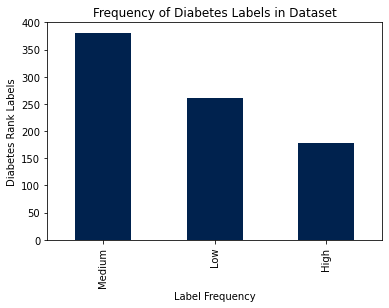

In [40]:
#check the distribution of labels in training set
MLdiabetes_data['diabetes_rank'].value_counts().plot(kind='bar', colormap='cividis')

plt.xlabel('Label Frequency')
plt.ylabel('Diabetes Rank Labels')
plt.title('Frequency of Diabetes Labels in Dataset')
plt.show()

In [41]:
print("Medium rank frequency: {}".format(MLdiabetes_data['diabetes_rank'].value_counts()[0]/len(MLdiabetes_data['diabetes_rank'])))
print("Low rank frequency: {}".format(MLdiabetes_data['diabetes_rank'].value_counts()[1]/len(MLdiabetes_data['diabetes_rank'])))
print("High rank frequency: {}".format(MLdiabetes_data['diabetes_rank'].value_counts()[2]/len(MLdiabetes_data['diabetes_rank'])))

Medium rank frequency: 0.46463414634146344
Low rank frequency: 0.3182926829268293
High rank frequency: 0.21707317073170732


In [42]:
MLdiabetes_data['diabetes_rank'].value_counts()

Medium    381
Low       261
High      178
Name: diabetes_rank, dtype: int64

### Maps using Shapefile

This map was created using shapefiles downloaded from the United States Census Bureau

Shapefile source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

State code source (STATEFP): https://www.census.gov/library/reference/code-lists/ansi.html#par_textimage_3

I adapted instructions on this tutorial to create the map: https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f

**DATA ENGINEERING**

Some Data Engineering is necessary to manipulate the Shapefile

In [43]:
#shapefile definition
shp_path = 'Shapefile_USA\cb_2018_us_county_500k.shp' 
shapef = shp.Reader(shp_path) #read shapefile

In [44]:
#This file helps to get state names based on code from Census Bureau
STATEFP_codes = pd.read_csv('Shapefile_USA\Shapefile_STATEFPcodes.csv') #state name codes downloaded from US Census Bureau
STATEFP_codes.drop(labels=['STATENS'], inplace=True, axis=1)
STATEFP_codes['STATEFP'] = STATEFP_codes['STATEFP'].astype(str) #convert to string
STATEFP_codes['STATEFP'] = STATEFP_codes['STATEFP'].apply(lambda x: '{0:0>2}'.format(x)) #add leading zeros

In [45]:
#Prepare dataframe for USA-County Maps
fields = [x[0] for x in shapef.fields][1:] #fetching shapefile headings
records = [list(i) for i in shapef.records()]  #fetching shapefile records
shps = [s.points for s in shapef.shapes()]  #fetching shapefile coordinates
df_spf = pd.DataFrame(columns=fields, data=records) #converting into pandas dataframe
df_spf = df_spf.assign(coords=shps) #add a column with the coordinates
df_spf = df_spf.merge(STATEFP_codes, on=['STATEFP'], how='left') #add state name/abbrev to df
df_spf.rename(columns={'NAME': 'county'}, inplace=True) #rename column for naming convention

#DATA ENGINEERING to ensure consistent county names with other data sources
df_spf = df_spf.assign(newcounty=df_spf['county'].str.replace('.', '')) #remove . from county names if any
df_spf.drop(labels=['county'], inplace=True, axis=1)
df_spf.rename(columns={'newcounty': 'county'}, inplace=True) 
df_spf.loc[df_spf['county'] == 'Doña Ana','county'] = 'Dona Ana' #for consistency across sources
df_spf.at[1697, 'county'] = 'St Louis City' #for consistency across sources
df_spf.at[1889, 'county'] = 'Baltimore City' #for consistency across sources
df_spf.at[2579, 'county'] = 'Richmond City' #for consistency across sources
df_spf.at[2893, 'county'] = 'Roanoke City' #for consistency across sources
df_spf.loc[(df_spf['county'] == 'Hampton') & (df_spf['state_name'] == 'Virginia'), 'county'] = 'Hampton City'  #for consistency across sources
df_spf.loc[(df_spf['county'] == 'Norfolk') & (df_spf['state_name'] == 'Virginia'), 'county'] = 'Norfolk City'  #for consistency across sources
df_spf.loc[(df_spf['county'] == 'Suffolk') & (df_spf['state_name'] == 'Virginia'), 'county'] = 'Suffolk City'  #for consistency across sources
indexes = df_spf.loc[df_spf['county'].isin(['Alexandria', 'Chesapeake', 'Newport News', 'Lynchburg', 'Portsmouth', 'Virginia Beach'])].index
for i, ind in enumerate(indexes):
    df_spf.at[ind, 'county'] = df_spf.at[ind, 'county'] + ' City' #for consistency across sources
df_spf['county'] = df_spf['county'].apply(lambda x: x.upper()) #for consistency across sources
df_spf = pd.merge(df_spf, MLdiabetes_data[['county', 'state_name', 'diabetes_rank', 'McDonaldsCount', 'population', 'per_capita_income']], \
                  on=['county', 'state_name'], how='left') # add diabetes_rank & McDonalds to define color in map
df_spf.loc[df_spf['diabetes_rank'].isnull(), 'diabetes_rank'] = 'out of scope' #pointer to identify the counties out of scope
df_spf.loc[df_spf['McDonaldsCount'].isnull(), 'McDonaldsCount'] = -100 #pointer to identify the counties out of scope
df_spf.loc[df_spf['population'].isnull(), 'population'] = 0 #pointer to identify the counties out of scope
df_spf.loc[df_spf['per_capita_income'].isnull(), 'per_capita_income'] = 0 #pointer to identify the counties out of scope

In [46]:
df_spf.isna().sum() #confirm no NaNs

STATEFP              0
COUNTYFP             0
COUNTYNS             0
AFFGEOID             0
GEOID                0
LSAD                 0
ALAND                0
AWATER               0
coords               0
state_abbrev         0
state_name           0
county               0
diabetes_rank        0
McDonaldsCount       0
population           0
per_capita_income    0
dtype: int64

In [47]:
#Check if all county names match other data sources
keys = ['county', 'state_name']
i1 = df_spf.set_index(keys).index
i2 = county_selection.set_index(keys).index
missing = county_selection[~i2.isin(i1)]

missing

,county,state_name,state_abbrev


**MAP: DIABETES RANK**

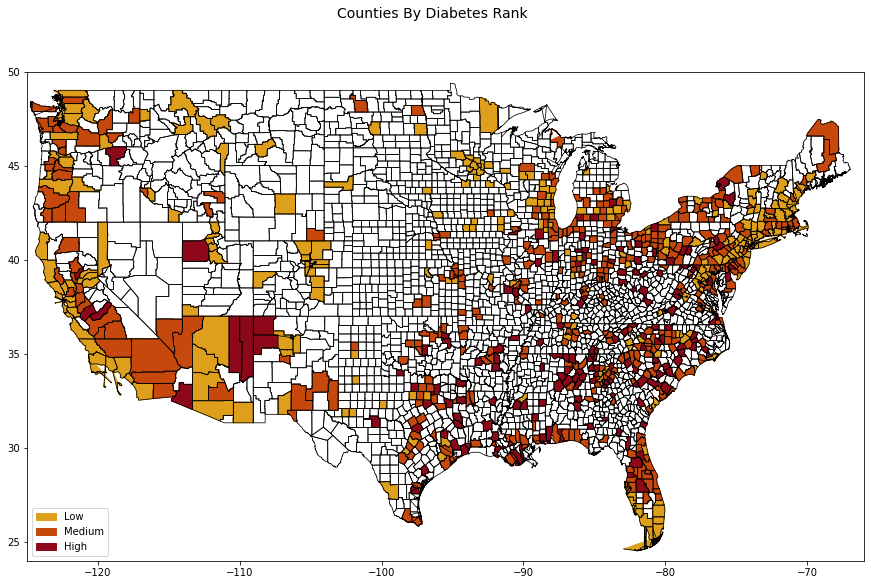

In [48]:
#color counties in scope based on diabetes rank
#since diabetes rank is a categorical variable, will manually set the corresponding colors
shp_path = 'Shapefile_USA\cb_2018_us_county_500k.shp' 
shapef = shp.Reader(shp_path) #read shapefile 
fig, ax = print_base_map(shp_path, (-125,-66), (24,50), title='Counties By Diabetes Rank') #use function for base map        
for r in range(0, len(df_spf)-1): #COLOR COUNTIES IN SCOPE
    rank = df_spf.at[r,'diabetes_rank'] #based on dataframe index, fetch diabetes rank
    shape_ex = shapef.shape(r) #fetch shape coords by index
    x_longit, y_latit = [], [] #store latitude & longitude in separate lists
    for coord in range(len(shape_ex.points)): #split x/y coordinates
        x_longit.append(shape_ex.points[coord][0]) 
        y_latit.append(shape_ex.points[coord][1])
    if rank == 'Low':
        ax.fill(x_longit,y_latit, color='#DEA01C', label='Low')
    elif rank == 'Medium':
        ax.fill(x_longit,y_latit, color='#C7480D', label='Medium')
    elif rank == 'High':
        ax.fill(x_longit,y_latit, color='#8D0919', label='High')   
high_patch = mpatches.Patch(color='#8D0919', label='High')
medium_patch = mpatches.Patch(color='#C7480D', label='Medium')
low_patch = mpatches.Patch(color='#DEA01C', label='Low')
plt.legend(handles=[low_patch, medium_patch, high_patch ])
plt.show();

**MAP: MCDONALD'S COUNT**

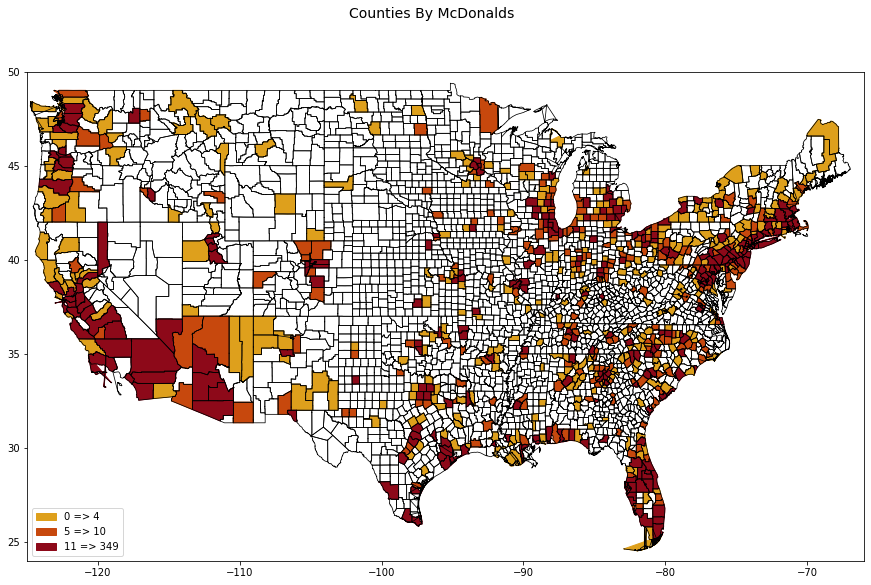

In [49]:
shp_path = 'Shapefile_USA\cb_2018_us_county_500k.shp' 
shapef = shp.Reader(shp_path) #read shapefile
df_spf_McDon = df_spf.sort_values(by=['McDonaldsCount']) #sort df by McDonalds value
df_spf_McDon = df_spf_McDon.loc[df_spf_McDon['McDonaldsCount'] > -1] #exclude counties out of scope
McDon =  df_spf_McDon['McDonaldsCount'] #series to create bins
color_ton, bins, handl= calc_color3(McDon) #routine to separate data into bins and assign color based on value
fig, ax = print_base_map(shp_path, (-125,-66), (24,50), title='Counties By McDonalds') #print base map
row_id = list(df_spf_McDon.index) #fetch the indexes of counties in scope
for j in range(len(row_id)-1): #COLOR COUNTIES IN SCOPE
    ident = row_id[j]
    shape_ex = shapef.shape(ident) #fetch shape coords by index
    x_longit, y_latit = [], [] #store latitude & longitude in separate lists
    for coord in range(len(shape_ex.points)): #split x/y coordinates
        x_longit.append(shape_ex.points[coord][0]) 
        y_latit.append(shape_ex.points[coord][1])
    ax.fill(x_longit,y_latit, color=color_ton[j]) #fill with color from calc_color function
plt.legend(handles=handl)
plt.show();

**MAP: POPULATION LEVEL**

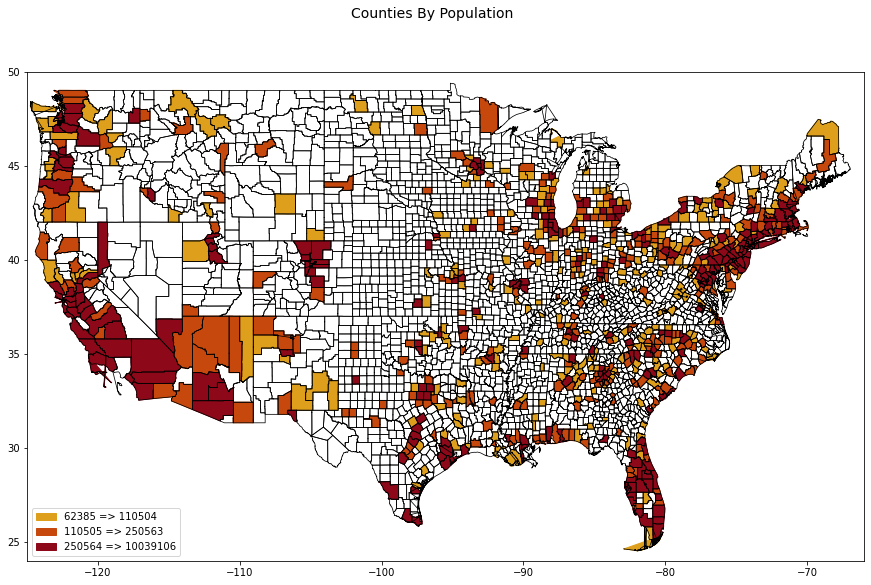

In [50]:
shp_path = 'Shapefile_USA\cb_2018_us_county_500k.shp' 
shapef = shp.Reader(shp_path) #read shapefile
df_spf_population = df_spf.sort_values(by=['population']) #sort df by population value
df_spf_population = df_spf_population.loc[df_spf_population['population'] > 0] #exclude counties out of scope
population =  df_spf_population['population'] #series to create bins
color_ton, bins, handl= calc_color3(population) #routine to separate data into bins and assign color based on value
fig, ax = print_base_map(shp_path, (-125,-66), (24,50), title='Counties By Population') #print base map
row_id = list(df_spf_population.index) #fetch the indexes of counties in scope
for j in range(len(row_id)-1): #COLOR COUNTIES IN SCOPE
    ident = row_id[j]
    shape_ex = shapef.shape(ident) #fetch shape coords by index
    x_longit, y_latit = [], [] #store latitude & longitude in separate lists
    for coord in range(len(shape_ex.points)): #split x/y coordinates
        x_longit.append(shape_ex.points[coord][0]) 
        y_latit.append(shape_ex.points[coord][1])
    ax.fill(x_longit,y_latit, color=color_ton[j]) #fill with color from calc_color function
plt.legend(handles=handl)
plt.show();

**MAP: PER CAPITA INCOME**

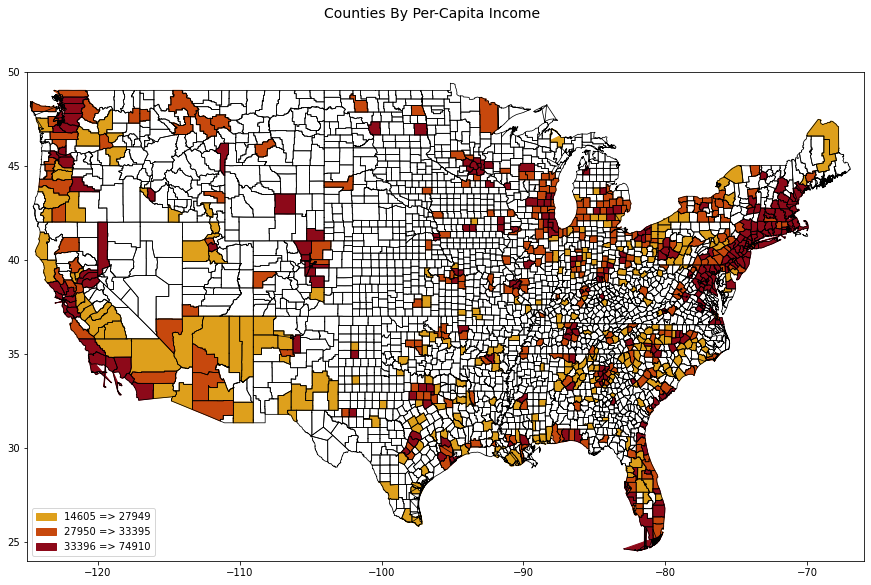

In [51]:
shp_path = 'Shapefile_USA\cb_2018_us_county_500k.shp' 
shapef = shp.Reader(shp_path) #read shapefile
df_spf_percapita = df_spf.sort_values(by=['per_capita_income']) #sort df by population value
df_spf_percapita = df_spf_percapita.loc[df_spf_percapita['per_capita_income'] > 0] #exclude counties out of scope
percapita =  df_spf_percapita['per_capita_income'] #series to create bins
color_ton, bins, handl= calc_color3(percapita) #routine to separate data into bins and assign color based on value
fig, ax = print_base_map(shp_path, (-125,-66), (24,50), title='Counties By Per-Capita Income') #print base map
row_id = list(df_spf_percapita.index) #fetch the indexes of counties in scope
for j in range(len(row_id)-1): #COLOR COUNTIES IN SCOPE
    ident = row_id[j]
    shape_ex = shapef.shape(ident) #fetch shape coords by index
    x_longit, y_latit = [], [] #store latitude & longitude in separate lists
    for coord in range(len(shape_ex.points)): #split x/y coordinates
        x_longit.append(shape_ex.points[coord][0]) 
        y_latit.append(shape_ex.points[coord][1])
    ax.fill(x_longit,y_latit, color=color_ton[j]) #fill with color from calc_color function
plt.legend(handles=handl)
plt.show();

### Food Access

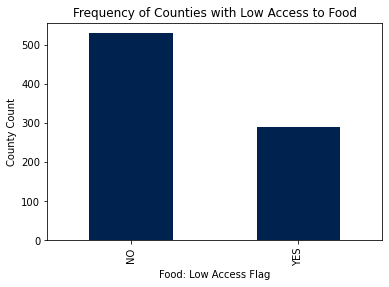

In [52]:
MLdiabetes_data['low_access_flag'].value_counts().plot(kind='bar', colormap='cividis')

plt.xlabel('Food: Low Access Flag')
plt.ylabel('County Count')
plt.title('Frequency of Counties with Low Access to Food')
plt.show()

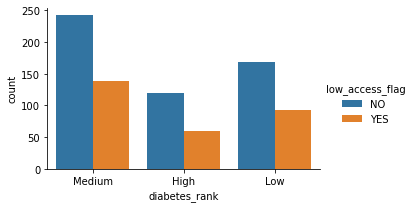

In [53]:
sns.catplot(x="diabetes_rank", hue='low_access_flag', data=MLdiabetes_data, kind="count", height=3, aspect=1.5);

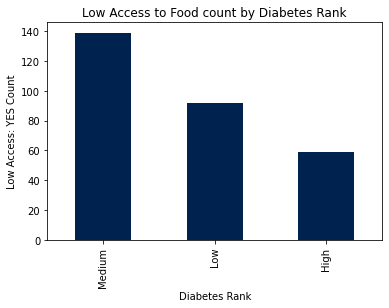

In [54]:
data = MLdiabetes_data.loc[MLdiabetes_data['low_access_flag'] == 'YES']
data['diabetes_rank'].value_counts().plot(kind='bar', colormap='cividis')

plt.xlabel('Diabetes Rank')
plt.ylabel('Low Access: YES Count')
plt.title('Low Access to Food count by Diabetes Rank')
plt.show()

### Best Features

Since this is a multilabel classification problem, I used the **SelectKBest** class from **sklearn.feature_selection** module. 
The scoring function used for the SelectKBest method was the f_classif, which computes the ANOVA F-test and estimates the degree of linear dependency between two random variables. This function returns an univariate score.

In [258]:
X = MLdiabetes_data.drop(labels=['diabetes_rank', 'county', 'name', 'state_name', 'state_abbrev'], axis=1)
y = MLdiabetes_data.loc[:, 'diabetes_rank']
#encode categorical data
foodAccess_dummies = pd.get_dummies(X['low_access_flag'], prefix='low_food_access') #Create dummies for food access
X = pd.concat([X, foodAccess_dummies], axis=1) #concat dummy columns
X = X.drop(['low_access_flag', 'low_food_access_NO'], axis=1) #drop original column and one category column to train model
bestfeatures = SelectKBest(k=10) #apply SelectKBest class to extract top best features
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1) #concat two dataframes for better visualization 
featureScores.columns = ['Variable','Score']  #naming the dataframe columns
featureScores.set_index('Variable', inplace=True)
top10 = featureScores.nlargest(10,'Score')  #select top 10
top50 = featureScores.nlargest(50,'Score')  #select top 10

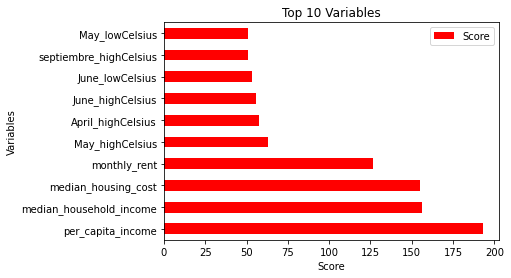

In [57]:
#check the distribution of labels in training set
top20.plot(kind='barh', colormap='autumn')
plt.xlabel('Score')
plt.ylabel('Variables')
plt.title('Top 10 Variables')
plt.show()

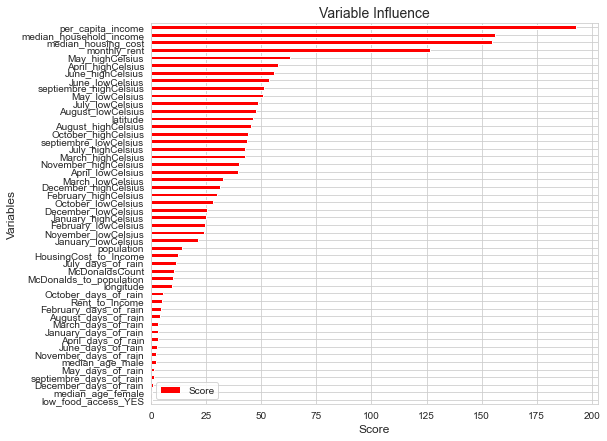

In [275]:
top50.sort_values('Score',inplace=True)
top50.plot(kind='barh', colormap='autumn', figsize=(8,7))
plt.xlabel('Score', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.title('Variable Influence', fontsize=14)
plt.show()

In [276]:
top50

,Score
Variable,
low_food_access_YES,0.295757
median_age_female,0.438660
December_days_of_rain,0.974418
septiembre_days_of_rain,1.158125
May_days_of_rain,1.419027
median_age_male,2.245068
November_days_of_rain,2.347636
June_days_of_rain,2.476830
April_days_of_rain,3.004129


### Income Related

In [58]:
MLdiabetes_data.describe()

,McDonaldsCount,monthly_rent,latitude,longitude,median_age_male,median_age_female,median_household_income,median_housing_cost,per_capita_income,April_days_of_rain,...,October_days_of_rain,October_highCelsius,October_lowCelsius,septiembre_days_of_rain,septiembre_highCelsius,septiembre_lowCelsius,population,McDonalds_to_population,HousingCost_to_Income,Rent_to_Income
count,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,...,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,8.200000e+02,820.000000,820.000000,820.000000
mean,13.359756,1283.056707,38.038430,-89.329047,37.693537,40.351341,62054.642683,1035.553659,32002.768293,6.984146,...,5.901220,20.543902,8.142683,6.010976,26.476829,14.113415,3.383873e+05,0.000040,0.199637,0.250577
std,22.288016,438.311644,4.838260,13.835691,4.573430,4.879832,16663.181977,331.518843,7897.249923,2.336940,...,1.995416,4.575432,4.524294,2.068693,3.692146,4.364701,5.918741e+05,0.000019,0.029194,0.059522
min,0.000000,562.000000,25.601043,-123.930611,24.200000,25.200000,30207.000000,246.000000,14605.000000,0.000000,...,0.000000,7.000000,-5.000000,0.000000,15.000000,-1.000000,6.238500e+04,0.000000,0.097726,0.133275
25%,4.000000,977.500000,34.532921,-94.822418,35.000000,37.500000,50461.500000,802.500000,26817.000000,5.000000,...,5.000000,17.000000,5.000000,5.000000,24.000000,11.000000,9.692175e+04,0.000031,0.179268,0.210072
50%,7.000000,1206.000000,38.900361,-85.514891,37.600000,40.100000,58735.500000,951.000000,30548.000000,7.000000,...,6.000000,20.000000,8.000000,6.000000,26.000000,14.000000,1.603765e+05,0.000042,0.194762,0.238609
75%,15.000000,1475.250000,41.562539,-79.957268,40.000000,43.100000,69359.750000,1189.750000,35643.750000,8.000000,...,7.000000,24.000000,11.000000,7.000000,29.000000,17.000000,3.480882e+05,0.000051,0.218294,0.278875
max,350.000000,4224.000000,48.842653,-68.649410,67.100000,67.800000,139915.000000,2507.000000,74911.000000,16.000000,...,16.000000,33.000000,25.000000,15.000000,39.000000,27.000000,1.003911e+07,0.000116,0.378402,0.597395


In [59]:
MLdiabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 820 entries, 0 to 819
Data columns (total 55 columns):
county                     820 non-null object
state_name                 820 non-null object
state_abbrev               820 non-null object
McDonaldsCount             820 non-null int64
monthly_rent               820 non-null float64
latitude                   820 non-null float64
longitude                  820 non-null float64
low_access_flag            820 non-null object
name                       820 non-null object
median_age_male            820 non-null float64
median_age_female          820 non-null float64
median_household_income    820 non-null float64
median_housing_cost        820 non-null float64
per_capita_income          820 non-null float64
April_days_of_rain         820 non-null int64
April_highCelsius          820 non-null int64
April_lowCelsius           820 non-null int64
August_days_of_rain        820 non-null int64
August_highCelsius         820 non-null int64


In [60]:
x_axis = MLdiabetes_data['median_age_male']
y_axis = MLdiabetes_data['per_capita_income']
color = MLdiabetes_data['diabetes_rank']

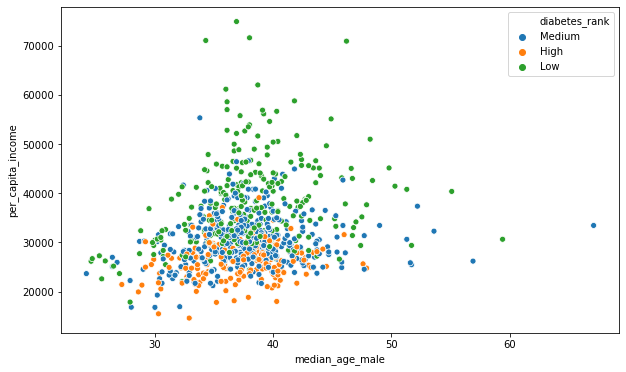

In [61]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x="median_age_male", y="per_capita_income", hue="diabetes_rank", data=MLdiabetes_data)

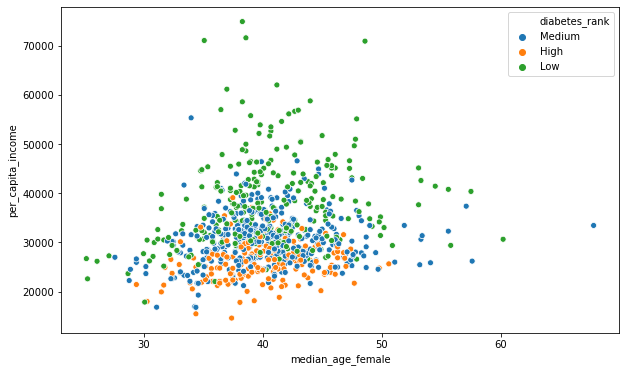

In [62]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x="median_age_female", y="per_capita_income", hue="diabetes_rank", data=MLdiabetes_data)

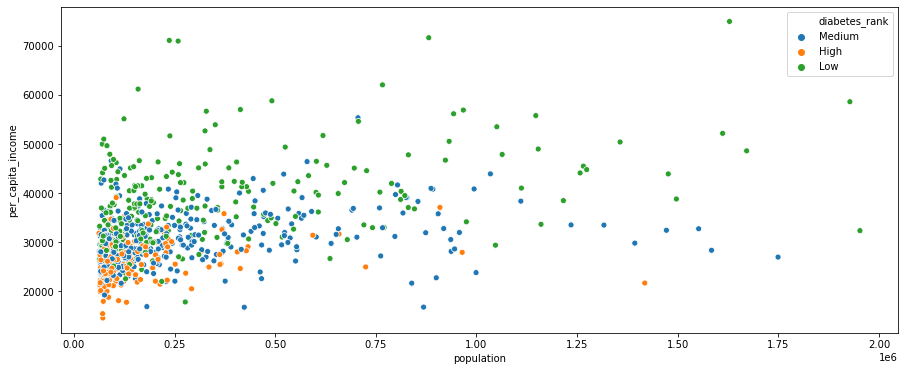

In [63]:
plt.figure(figsize=(15,6))
scatter_subset = MLdiabetes_data.loc[MLdiabetes_data['population'] < 2000000]
ax = sns.scatterplot(x="population", y="per_capita_income", hue="diabetes_rank", data=scatter_subset)

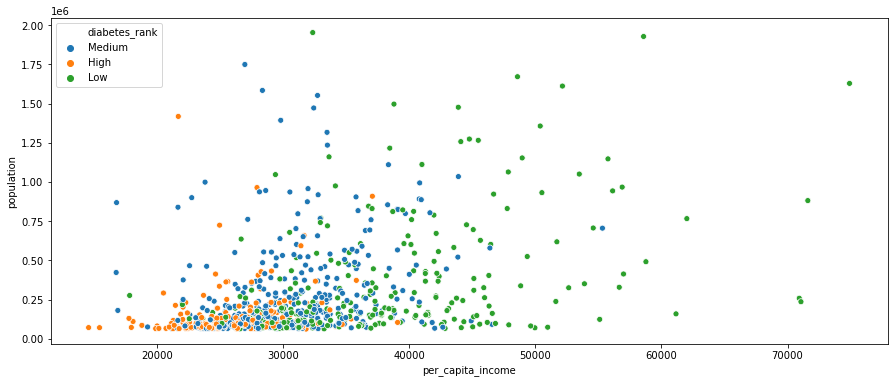

In [65]:
plt.figure(figsize=(15,6))
scatter_subset = MLdiabetes_data.loc[MLdiabetes_data['population'] < 2000000]
ax = sns.scatterplot(x="per_capita_income", y="population", hue="diabetes_rank", data=scatter_subset)

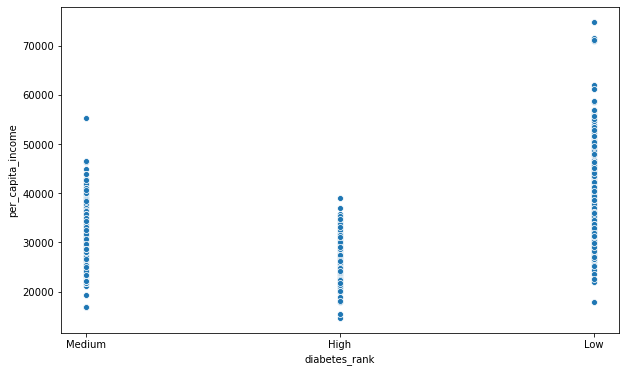

In [68]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x="diabetes_rank", y="per_capita_income", data=MLdiabetes_data)

Scatter plots to visualize the per capita income relation with diabetes levels / median age

In [243]:
#Data definition for percapita income-age scatter plots
high_pc = MLdiabetes_data.loc[MLdiabetes_data['diabetes_rank'] == 'High']['per_capita_income']
medium_pc = MLdiabetes_data.loc[MLdiabetes_data['diabetes_rank'] == 'Medium']['per_capita_income']
low_pc = MLdiabetes_data.loc[MLdiabetes_data['diabetes_rank'] == 'Low']['per_capita_income']

high_med_age = MLdiabetes_data.loc[MLdiabetes_data['diabetes_rank'] == 'High']['median_age_male']
medium_med_age = MLdiabetes_data.loc[MLdiabetes_data['diabetes_rank'] == 'Medium']['median_age_male']
low_med_age = MLdiabetes_data.loc[MLdiabetes_data['diabetes_rank'] == 'Low']['median_age_male']

high_med_age_fem = MLdiabetes_data.loc[MLdiabetes_data['diabetes_rank'] == 'High']['median_age_female']
medium_med_age_fem = MLdiabetes_data.loc[MLdiabetes_data['diabetes_rank'] == 'Medium']['median_age_female']
low_med_age_fem = MLdiabetes_data.loc[MLdiabetes_data['diabetes_rank'] == 'Low']['median_age_female']

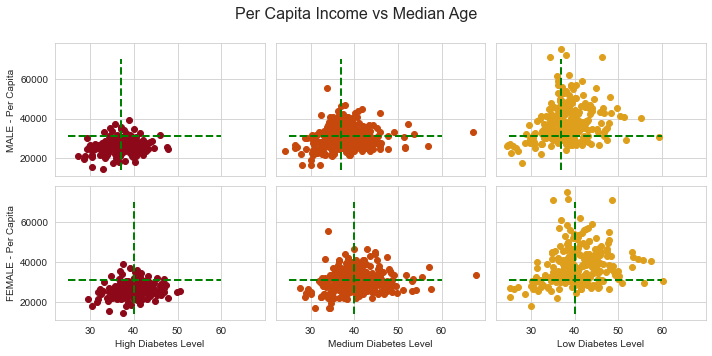

In [242]:
#Per Capita Income vs Median Male/Female age
fig, axs = plt.subplots(2,3, figsize=(10,5), sharex=True, sharey=True)
sns.set_style("whitegrid")
axs[0,0].scatter(high_med_age, high_pc, color='#8D0919')
axs[0,1].scatter(medium_med_age, medium_pc, color='#C7480D')
axs[0,2].scatter(low_med_age, low_pc, color='#DEA01C')

axs[1,0].scatter(high_med_age_fem, high_pc, color='#8D0919')
axs[1,1].scatter(medium_med_age_fem, medium_pc, color='#C7480D')
axs[1,2].scatter(low_med_age_fem, low_pc, color='#DEA01C')

# axs[0,0].set_xlabel('Median Male Age - High Diabetes Level')
# axs[0,1].set_xlabel('Median Male Age - Medium Diabetes Level')
# axs[0,2].set_xlabel('Median Male Age - Low Diabetes Level')
axs[0,0].set_ylabel('MALE - Per Capita')

# axs[1,0].set_xlabel('Median Female Age - High Diabetes Level')
# axs[1,1].set_xlabel('Median Female Age - Medium Diabetes Level')
# axs[1,2].set_xlabel('Median Female Age - Low Diabetes Level')
axs[1,0].set_xlabel('High Diabetes Level')
axs[1,1].set_xlabel('Medium Diabetes Level')
axs[1,2].set_xlabel('Low Diabetes Level')
axs[1,0].set_ylabel('FEMALE - Per Capita')

#Horizontal and vertical lines marking median values for reference
axs[0,0].plot((25, 60), (31000, 31000), 'g--', lw=2)
axs[0,1].plot((25, 60), (31000, 31000), 'g--', lw=2)
axs[0,2].plot((25, 60), (31000, 31000), 'g--', lw=2)
axs[0,0].plot((37, 37), (14000, 70000), 'g--', lw=2)
axs[0,1].plot((37, 37), (14000, 70000), 'g--', lw=2)
axs[0,2].plot((37, 37), (14000, 70000), 'g--', lw=2)

axs[1,0].plot((25, 60), (31000, 31000), 'g--', lw=2)
axs[1,1].plot((25, 60), (31000, 31000), 'g--', lw=2)
axs[1,2].plot((25, 60), (31000, 31000), 'g--', lw=2)
axs[1,0].plot((40, 40), (14000, 70000), 'g--', lw=2)
axs[1,1].plot((40, 40), (14000, 70000), 'g--', lw=2)
axs[1,2].plot((40, 40), (14000, 70000), 'g--', lw=2)

fig.suptitle('Per Capita Income vs Median Age', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

Box plots to compliment the scatter plots

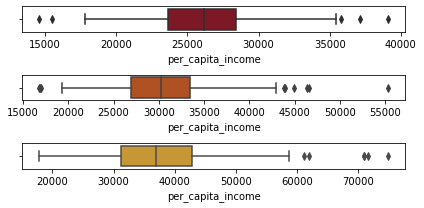

In [145]:
#Income related boxplots
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(6,3))
sns.boxplot(x=high_pc, ax=ax1, color="#8D0919")
sns.boxplot(x=medium_pc, ax = ax2, color="#C7480D")
sns.boxplot(x=low_pc, ax=ax3, color="#DEA01C")
plt.tight_layout()

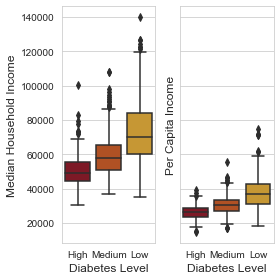

In [250]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,4), sharey=True)
sns.set_style("whitegrid")
sns.boxplot(x="diabetes_rank", y="median_household_income", data=MLdiabetes_data, order=["High", "Medium", "Low"], 
            palette=my_pal, ax=ax1)
sns.boxplot(x="diabetes_rank", y="per_capita_income", data=MLdiabetes_data, order=["High", "Medium", "Low"], 
                 palette=my_pal, ax=ax2)
ax1.set_ylabel('Median Household Income', fontsize=12)
ax2.set_ylabel('Per Capita Income', fontsize=12)
ax1.set_xlabel('Diabetes Level', fontsize=12)
ax2.set_xlabel('Diabetes Level', fontsize=12)

fig.tight_layout()

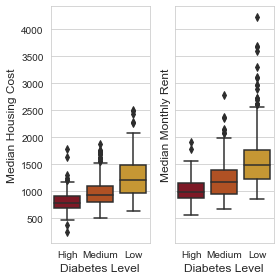

In [248]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,4), sharey=True)
sns.set_style("whitegrid")
sns.boxplot(x="diabetes_rank", y="median_housing_cost", data=MLdiabetes_data, order=["High", "Medium", "Low"], 
            palette=my_pal, ax=ax1)
sns.boxplot(x="diabetes_rank", y="monthly_rent", data=MLdiabetes_data, order=["High", "Medium", "Low"], 
                 palette=my_pal, ax=ax2)
ax1.set_ylabel('Median Housing Cost', fontsize=12)
ax2.set_ylabel('Median Monthly Rent', fontsize=12)
ax1.set_xlabel('Diabetes Level', fontsize=12)
ax2.set_xlabel('Diabetes Level', fontsize=12)
plt.tight_layout()

### Covariance

### Outliers

- Some outliers between number of McDonalds & population
- The Mcdonalds_to_population rate decreased the number of outliers significantly



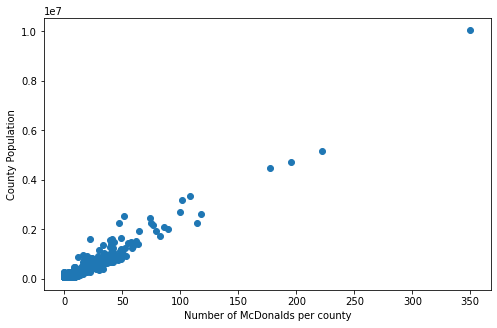

In [84]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(MLdiabetes_data['McDonaldsCount'], MLdiabetes_data['population'])
ax.set_xlabel('Number of McDonalds per county')
ax.set_ylabel('County Population')
plt.show()

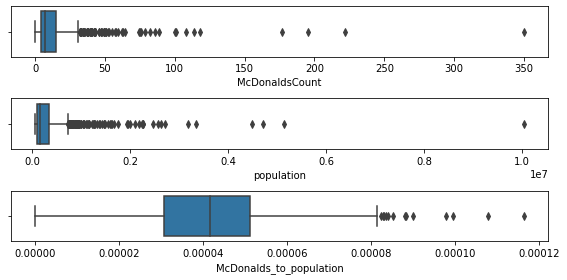

In [85]:
#Population level related boxplots
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,4))
sns.boxplot(x=MLdiabetes_data['McDonaldsCount'], ax=ax1)
sns.boxplot(x=MLdiabetes_data['population'], ax = ax2)
sns.boxplot(x=MLdiabetes_data['McDonalds_to_population'], ax=ax3)
plt.tight_layout()

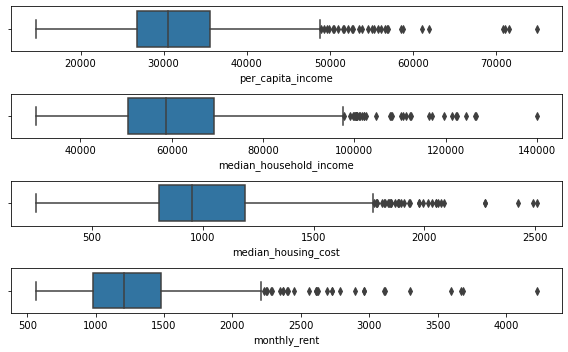

In [142]:
#Income related boxplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(8,5))
sns.boxplot(x=MLdiabetes_data['per_capita_income'], ax=ax1)
sns.boxplot(x=MLdiabetes_data['median_household_income'], ax = ax2)
sns.boxplot(x=MLdiabetes_data['median_housing_cost'], ax=ax3)
sns.boxplot(x=MLdiabetes_data['monthly_rent'], ax=ax4)
plt.tight_layout()

In [ ]:
#Income related boxplots
fig, ax = plt.subplots(2, figsize=(8,3))
sns.boxplot(x=MLdiabetes_data['HousingCost_to_Income'], ax=ax[0])
sns.boxplot(x=MLdiabetes_data['Rent_to_Income'], ax=ax[1])
plt.tight_layout()

## Machine Learning 

### Prepare data for ML

In [ ]:
#train/test split
X = MLdiabetes_data.drop(labels=['diabetes_rank', 'county', 'name', 'state_name', 'state_abbrev'], axis=1)
y = MLdiabetes_data.loc[:, 'diabetes_rank']

#encode categorical data
foodAccess_dummies = pd.get_dummies(X['low_access_flag'], prefix='low_food_access') #Create dummies for food access
X = pd.concat([X, foodAccess_dummies], axis=1) #concat dummy columns
X = X.drop(['low_access_flag', 'low_food_access_NO'], axis=1) #drop original column and one category column to train model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 

In [ ]:
X.info()

### Random Forest

In [ ]:
#defined the parameters to try on each pipeline
#PCA and variable scaling were tested on some pipelines

params = {'RF__criterion': ['gini', 'entropy'],
        'RF__max_depth': [2, 4, 5, 6],
        'RF__min_samples_split': [2, 0.1, 0.2, 0.3]}
RF1_gridsearch = GridSearchCV(estimator = Pipeline([('RF', RandomForestClassifier(random_state=42))]),
                            param_grid = params,
                            scoring = 'accuracy', 
                            cv = 10)
RF2_gridsearch = GridSearchCV(estimator = Pipeline([('pca', PCA(n_components=10)),
                                        ('RF', RandomForestClassifier(random_state=42))]),
                            param_grid = params,
                            scoring = 'accuracy', 
                            cv = 10)
RF3_gridsearch = GridSearchCV(estimator = Pipeline([('scl', StandardScaler()),
                                        ('pca', PCA(n_components=10)),
                                        ('RF', RandomForestClassifier(random_state=42))]),
                            param_grid = params,
                            scoring = 'accuracy', 
                            cv = 10)
RFgrids = [RF1_gridsearch, RF2_gridsearch, RF3_gridsearch]
for i,g in enumerate(RFgrids):
    g.fit(X_train, y_train)

In [ ]:
#Random Forest GridSearch Metrics and Scoring 
labels = ['High', 'Medium', 'Low']
gridsearch_metrics_scoring(RFgrids, labels, X_test, y_test)

In [ ]:
#plot feature importance of best Random Forest
#Train a forest with best parameters as GridSearch does not have feature_importance method
forest = RandomForestClassifier(n_estimators=100, max_depth= 6, criterion='gini', random_state=42, min_samples_split=2)
forest.fit(X_train, y_train)
plot_feature_importances(forest)

### SVM

- SVM is sensitive to unscaled data, therefore we need to scale numeric variables
- The sklearn documentation states that SVM, with RBF kernel,  assumes that all the features are centered around zero and variance is of the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

Function to plot confusion matrix:
https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python


In [ ]:
# Create the grid parameter
grid = {'svm__kernel': ['rbf', 'poly'],
         'svm__C': [16, 25, 28, 32],
         'svm__degree': [2,3,5],
         'svm__gamma': [0.001, 0.01]}

# Create the grid, with "pipe" as the estimator
SVM1_gridsearch = GridSearchCV(estimator=Pipeline([('scl', StandardScaler()),
                                    ('pca', PCA(n_components=10)),
                                    ('svm', svm.SVC(random_state=42))]),
                                    param_grid=grid,
                                    scoring='accuracy',
                                    cv=10)
SVM2_gridsearch = GridSearchCV(estimator=Pipeline([('scl', StandardScaler()),
                                    ('svm', svm.SVC(random_state=42))]),
                                    param_grid=grid,
                                    scoring='accuracy',
                                    cv=10)
SVM3_gridsearch = GridSearchCV(estimator=Pipeline([('fs', SelectKBest(score_func=f_classif, k=20)),
                                    ('scl', StandardScaler()),
                                    ('svm', svm.SVC(random_state=42))]),
                                    param_grid=grid,
                                    scoring='accuracy',
                                    cv=10)
SVMgrids = [SVM1_gridsearch, SVM2_gridsearch, SVM3_gridsearch]
for g in SVMgrids:
    g.fit(X_train, y_train)

In [ ]:
#Evaluate gridsearch performances
#Print metrics and scores
labels = ['High', 'Medium', 'Low']
gridsearch_metrics_scoring(SVMgrids, labels, X_test, y_test)

### K-Nearest Neighbors

In [ ]:
# Create the grid parameter
grid = {'knn__n_neighbors': [15, 20, 25, 30, 35]}

# Create the grid, with "pipe" as the estimator
KNN1_gridsearch = GridSearchCV(estimator=Pipeline([('scl', StandardScaler()),
                                    ('pca', PCA(n_components=10)),
                                    ('knn', KNeighborsClassifier())]),
                                  param_grid=grid,
                                  scoring='accuracy',
                                  cv=10)

KNN2_gridsearch = GridSearchCV(estimator=Pipeline([('scl', StandardScaler()),
                                    ('knn', KNeighborsClassifier())]),
                                  param_grid=grid,
                                  scoring='accuracy',
                                  cv=10)


KNNgrids = [KNN1_gridsearch, KNN2_gridsearch]
for g in KNNgrids:
    g.fit(X_train, y_train)

In [ ]:
#Evaluate gridsearch performances
#Print metrics and scores
labels = ['High', 'Medium', 'Low']
gridsearch_metrics_scoring(KNNgrids, labels, X_test, y_test)

### Adaboost/Gradient Boosting

In [ ]:
params = {'AB__n_estimators': [100],
        'AB__learning_rate': [0.2, 0.8, 0.7, 0.6],
         'AB__base_estimator': [DecisionTreeClassifier(max_depth=1), 
                                RandomForestClassifier(random_state=42, criterion='gini', max_depth=6)]}
params2 = {'GB__learning_rate': [0.2, 0.6, 0.7, 0.8],
          'GB__max_depth': [5, 6]}
params3 = {'XGB__learning_rate': [0.2, 0.6],
            'XGB__max_depth': [5,6],
            'XGB__min_child_weight': [1, 2],
            'XGB__subsample': [0.5, 0.7],
            'XGB__n_estimators': [100]}

AdaB_gridsearch = GridSearchCV(estimator = Pipeline([('AB', AdaBoostClassifier(random_state=42))]),
                            param_grid = params,
                            scoring = 'accuracy', 
                            cv = 10)
AdaB2_gridsearch = GridSearchCV(estimator = Pipeline([('fs', SelectKBest(score_func=f_classif, k=20)),
                                            ('AB', AdaBoostClassifier(random_state=42))]),
                            param_grid = params,
                            scoring = 'accuracy', 
                            cv = 10)
GB_gridsearch = GridSearchCV(estimator = Pipeline([('GB', GradientBoostingClassifier(random_state=42))]),
                            param_grid = params2,
                            scoring = 'accuracy', 
                            cv = 10)
GB2_gridsearch = GridSearchCV(estimator = Pipeline([('fs', SelectKBest(score_func=f_classif, k=20)),
                                                    ('GB', GradientBoostingClassifier(random_state=42))]),
                            param_grid = params2,
                            scoring = 'accuracy', 
                            cv = 10)
XGB_gridsearch = GridSearchCV(estimator = Pipeline([('XGB', XGBClassifier(random_state=42))]),
                            param_grid = params3,
                            scoring = 'accuracy', 
                            cv = 10)

grid = [AdaB_gridsearch, AdaB2_gridsearch, GB_gridsearch, GB2_gridsearch, XGB_gridsearch]
for g in grid:
    g.fit(X_train, y_train)

In [ ]:
labels = ['High', 'Medium', 'Low']
gridsearch_metrics_scoring(grid, labels, X_test, y_test)

In [ ]:
import inspect
from sklearn.utils.testing import all_estimators
for name, clf in all_estimators(type_filter='classifier'):
    if 'sample_weight' in inspect.getargspec(clf().fit)[0]:
        print (name)

In [ ]:
###########MISCELLANEOUS######################

In [ ]:
#SVM Pipelines
pipe_SVM1 = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=10)),
                    ('svm', svm.SVC(random_state=42))])

pipe_SVM2 = Pipeline([('scl', StandardScaler()),
                    ('svm', svm.SVC(random_state=42))])

# Create the grid parameter
grid = {'svm__kernel': ['rbf', 'poly'],
         'svm__C': [16, 25, 28, 32],
         'svm__degree': [2,3,5],
         'svm__gamma': [0.001, 0.01]}

# Create the grid, with "pipe" as the estimator
gridsearch1 = GridSearchCV(estimator=pipe_SVM1,
                  param_grid=grid,
                  scoring='accuracy',
                  cv=10)

gridsearch2 = GridSearchCV(estimator=pipe_SVM2,
                  param_grid=grid,
                  scoring='accuracy',
                  cv=10)

# grids = [gridsearch1, gridsearch2]
# for g in grids:
#     g.fit(X_train, y_train)

In [ ]:
#RF Pipelines
#Create Pipelines to train for Random Forests
pipe_RF1 = Pipeline([('RF', RandomForestClassifier(random_state=42))])

pipe_RF2 = Pipeline([('pca', PCA(n_components=10)),
                    ('RF', RandomForestClassifier(random_state=42))])

pipe_RF3 = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=10)),
                    ('RF', RandomForestClassifier(random_state=42))])

params = {'RF__criterion': ['gini', 'entropy'],
        'RF__max_depth': [2, 4, 5, 6],
        'RF__min_samples_split': [2, 0.1, 0.2, 0.3]}

grid_RF1 = GridSearchCV(estimator = pipe_RF1,
                        param_grid = params,
                        scoring = 'accuracy', 
                        cv = 10)
grid_RF2 = GridSearchCV(estimator = pipe_RF2,
                        param_grid = params,
                        scoring = 'accuracy', 
                        cv = 10)
grid_RF3 = GridSearchCV(estimator = pipe_RF3,
                        param_grid = params,
                        scoring = 'accuracy', 
                        cv = 10)
                        
# RFgrids = [grid_RF1, grid_RF2, grid_RF3]
# for i,g in enumerate(RFgrids):
#     g.fit(X_train, y_train) #use X and y since we are doing crossvalidation

In [ ]:
clf = AdaBoostClassifier(n_estimators=100, random_state=42,  learning_rate=0.8)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))

In [ ]:
MLdiabetes_data.hist(figsize = (40, 15))
plt.show()

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
# Feature extraction
test = SelectKBest(score_func=f_classif, k=10).fit_transform(X, y)
feature_names = list(MLdiabetes_data.columns.values)

test.get_support()
# new_features = [] # The list of your K best features

# for bool, feature in zip(mask, feature_names):
#     if bool:
#         new_features.append(feature)


# mask = test.get_support()
# new_features = features_dataframe.columns[mask]
        
        
# fit = test.fit(X, y)



# Summarize scores
# np.set_printoptions(precision=3)
# print(fit.scores_)

# features = fit.transform(X)
# Summarize selected features
# print(features[0:5,:])

In [ ]:
feature_names = list(MLdiabetes_data.columns.values)

In [ ]:
mask = select_k_best_classifier.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

In [ ]:
plt.figure(figsize=(12,10))
cor = MLdiabetes_data.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

In [ ]:
dfscores